### Exp: full-body
客户要求，人体面积50%以内不纳入person类检出（实测场景下多为挥手）
试图最低限度修改模型，取消小面积肢体的检出

#### try1
冻结所有网络前置层，在每组anchor输出向量中添加一维手部检测，在[HGP](https://paperswithcode.com/dataset/hgp) / [EgoHands](https://public.roboflow.com/object-detection/hands) 数据集上fine-tune

In [1]:
import sys
import torch
import torch.nn as nn
# import matplotlib
# matplotlib.use('TkAgg')
sys.path.append('..')

import object_detection.yolov5_ultralytics.model as yolo_u

yolo_u.ACTIVATION = nn.SiLU
model = yolo_u.yolov5n(80, weights="../.yolov5_checkpoints/yolov5n_sd.pt").eval()

transferred 349/349 items from ../.yolov5_checkpoints/yolov5n_sd.pt


/opt/homebrew/anaconda3/envs/dev/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


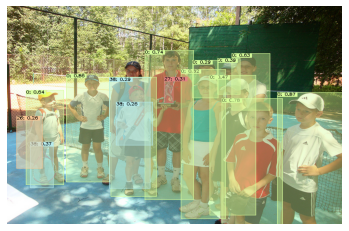

In [2]:
# Test raw model
import cv2
from test_utils.detection_test import detect, uniform_scale
from test_utils.detection_visualize import Canvas
image = cv2.imread('/Volumes/ASM236X/coco/images/val2017/000000001000.jpg')
image = uniform_scale(image, 640)
canvas = Canvas(backend='plt')
detect(model, image, canvas)
del canvas

In [3]:
# Transfer box/obj weight data
print(model.detect.m)
for layer in model.detect.m:
    print(layer.weight.shape, layer.bias.shape)
# 255 = 3x(4+1+80)  bs, self.na, self.no, ny, nx
raw_m = model.detect.m
hand_m = nn.ModuleList(nn.Conv2d(x, 6 * 3, 1) for x in (64, 128, 256))  # output conv
for i in range(3):
    for j in range(3):
        hand_m[i].weight.data[6*j:6*j+5] = raw_m[i].weight.data[85*j:85*j+5].clone()  # 0-5 85-90 170-175
        hand_m[i].bias.data[6*j:6*j+5]  = raw_m[i].bias.data[85*j:85*j+5].clone()
        hand_m[i].weight.data[6*j+5] = 0
        hand_m[i].bias.data[6*j+5] = 1
model.detect.nc = 1
model.detect.no = 5+1
setattr(model.detect, 'm', hand_m)

ModuleList(
  (0): Conv2d(64, 255, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(128, 255, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(256, 255, kernel_size=(1, 1), stride=(1, 1))
)
torch.Size([255, 64, 1, 1]) torch.Size([255])
torch.Size([255, 128, 1, 1]) torch.Size([255])
torch.Size([255, 256, 1, 1]) torch.Size([255])


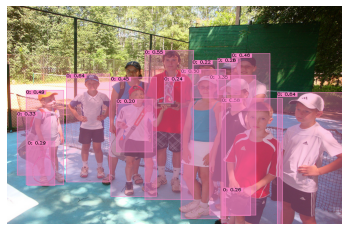

In [4]:
# Test if new model works properly
import cv2
from test_utils.detection_test import detect, uniform_scale
from test_utils.detection_visualize import Canvas
image = cv2.imread('/Volumes/ASM236X/coco/images/val2017/000000001000.jpg')
image = uniform_scale(image, 640)
canvas = Canvas(backend='plt')
detect(model, image, canvas)


In [5]:
# Freeze model for fine-tuning (train obj loss only)
frozen_params = [k for k, _ in model.named_parameters()]
frozen_params = [x for x in frozen_params if 'detect.m' not in x]

for k, v in model.named_parameters():
        v.requires_grad = True
        if frozen_params is not None and any(x == k for x in frozen_params):
            v.requires_grad = False

print('trainable parameters:')
for name, x in model.named_parameters():
    if x.requires_grad:
        print(name, x.shape)


trainable parameters:
detect.m.0.weight torch.Size([18, 64, 1, 1])
detect.m.0.bias torch.Size([18])
detect.m.1.weight torch.Size([18, 128, 1, 1])
detect.m.1.bias torch.Size([18])
detect.m.2.weight torch.Size([18, 256, 1, 1])
detect.m.2.bias torch.Size([18])


In [6]:
# Process data
# 只需要手部标注 (cid=2)
if False:
    import os
    labels_root = '/Volumes/ASM236X/HGP/labels'
    output_root = labels_root.replace('/labels','/labels.fullbody')
    for dataset in ("train2017", "val2017"):
        image_dir = f'{labels_root}/{dataset}'
        output_dir = f'{output_root}/{dataset}'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # traverse through images
        print(image_dir)
        assert os.path.exists(image_dir)
        for file_name in os.listdir(image_dir):
            if not file_name.startswith('._') and file_name.endswith('.txt'):
                labels = []
                with open(f'{image_dir}/{file_name}', 'r') as f:
                    for line in f.readlines():
                        c, x, y, w, h = [float(m) for m in line.split(' ')]
                        if int(c) == 2:
                            labels.append(f'{0} {x} {y} {w} {h}')
                with open(f'{output_dir}/{file_name}', 'w') as f:
                    for line in labels:
                        f.write(f'{line}\n')
    os.system(f'mv {labels_root} {labels_root}.raw')
    os.system(f'ln -s {output_root}  {labels_root}')


In [8]:
# Fine-tune on HGP dataset
if True:
    from object_detection.training_utils.default_settings import DefaultSettings
    from object_detection.training_utils.trainer import train

    settings = DefaultSettings()
    settings.trainset_path = "/Volumes/ASM236X/HGP/images/val2017"
    settings.valset_path = "/Volumes/ASM236X/HGP/images/val2017"
    settings.lr0 = 0.001
    settings.nc = 1
    settings.names = ['hand']
    settings.auto_anchor = False
    settings.batch_size = 8
    settings.frozen_params = frozen_params
    settings.save_dir = "runs/yolov5n_fullbody"
    train(model, settings, device='cpu')

# 仅finetune单层效果可能并不好，考虑是否直接加数据

2022-06-15 19:22:34.732 | SUCCESS  | object_detection.training_utils.general:check_before_training:128 - model check passed


albumentations: Blur(always_apply=False, p=0.01, blur_limit=(3, 7)), MedianBlur(always_apply=False, p=0.01, blur_limit=(3, 7)), ToGray(always_apply=False, p=0.01), CLAHE(always_apply=False, p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


Scanning '/Volumes/ASM236X/HGP/labels/val2017.cache' images and labels... 210 found, 0 missing, 18 empty, 0 corrupt: 100%|██████████| 210/210 [00:00<?, ?it/s]
Scanning '/Volumes/ASM236X/HGP/labels/val2017.cache' images and labels... 210 found, 0 missing, 18 empty, 0 corrupt: 100%|██████████| 210/210 [00:00<?, ?it/s]



     epoch   gpu_mem       box       obj       cls


     0/299        0G   0.06966   0.02488         0: 100%|██████████| 27/27 [01:15<00:00,  2.79s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.85s/it]
2022-06-15 19:24:32.761 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.04340959974631642, save model as runs/yolov5n_fullbody.6/best.pt


                 all        210        280      0.244      0.207      0.126     0.0343      0.224

     epoch   gpu_mem       box       obj       cls


     1/299        0G   0.06736   0.02415         0: 100%|██████████| 27/27 [00:52<00:00,  1.94s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:40<00:00,  2.89s/it]
2022-06-15 19:26:05.664 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.05170908111050483, save model as runs/yolov5n_fullbody.6/best.pt


                 all        210        280      0.273      0.225      0.158     0.0399      0.247

     epoch   gpu_mem       box       obj       cls


     2/299        0G   0.06607   0.02541         0: 100%|██████████| 27/27 [00:49<00:00,  1.85s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.84s/it]


                 all        210        280      0.271      0.214      0.149     0.0399      0.239

     epoch   gpu_mem       box       obj       cls


     3/299        0G   0.06588   0.02502         0: 100%|██████████| 27/27 [00:49<00:00,  1.83s/it]
               class     images     labels          P          R     mAP@.5 mAP@.5:.95         f1: 100%|██████████| 14/14 [00:39<00:00,  2.84s/it]
2022-06-15 19:29:04.747 | SUCCESS  | object_detection.training_utils.trainer:train:71 - fitness = 0.05948945147776109, save model as runs/yolov5n_fullbody.6/best.pt


                 all        210        280      0.299      0.232      0.166     0.0476      0.261

     epoch   gpu_mem       box       obj       cls


     4/299        0G   0.06465   0.02601         0:  15%|█▍        | 4/27 [00:08<00:47,  2.06s/it]


KeyboardInterrupt: 

In [ ]:
# Try model
# print(torch.sigmoid(torch.ones(1)))

In [ ]:
# Fuse